## Distracted Driver Detection

### Getting started

Import libraries and data

In [35]:
import numpy as np
import pandas as pd
from IPython.display import display
import os
import matplotlib.pyplot as plt
import cv2
import random

from keras.utils import np_utils
from keras import initializers as init
from keras.preprocessing import image
from keras.applications import *
from keras.models import *
from keras.layers import *
from keras import optimizers

import h5py

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint
import seaborn as sns

# show result in notebook
%matplotlib inline


In [2]:
#import driver ID of training dataset
driver_data = pd.read_csv('driver_imgs_list.csv')

#display first record
display(driver_data.head(n=1))

,subject,classname,img
0,p002,c0,img_44733.jpg


### Split train dataset and validation dataset

randomly select 5 drivers for validation

In [3]:
print('total images:',driver_data.subject.count())
diver_list = []
for data in driver_data.subject:
    if data not in diver_list:
        diver_list.append(data)

print('tatal drivers:', len(diver_list))

train_files = []
valid_files = []
train_lable = []
valid_lable = []
size224 = (224, 224)
size299 = (299, 299)
classes = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']  

def split_val_drivers(seed, val_num):
    train_files.clear()
    valid_files.clear()
    train_lable.clear()
    valid_lable.clear()
    np.random.seed(seed)
    driver_valid = np.random.choice(diver_list, val_num)
    driver_train=diver_list
    for dv in driver_valid:
        driver_train.remove(dv)
    for i in range(driver_data.subject.count()):
        if driver_data.subject[i] in driver_valid:
            valid_files.append('train/'+driver_data.classname[i]+'/'+driver_data.img[i])
            valid_lable.append(np_utils.to_categorical(int(driver_data.classname[i][1]), 10))
        else:
            train_files.append('train/'+driver_data.classname[i]+'/'+driver_data.img[i])
            train_lable.append(np_utils.to_categorical(int(driver_data.classname[i][1]), 10))
    print('drivers for validation:',driver_valid)
    print('drivers for training:',driver_train)

split_val_drivers(825, 5)       

total images: 22424
tatal drivers: 26
drivers for validation: ['p015' 'p066' 'p002' 'p021' 'p047']
drivers for training: ['p012', 'p014', 'p016', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p072', 'p075', 'p081']


In [4]:
Batch=16

#input tensor function
def path_to_tensor(img_path, i_size):
    img = image.load_img(img_path, target_size=i_size)
    # convert PIL.Image.Image type to 3D tensor with shape (width, height, 3)
    x = image.img_to_array(img)
    # return 4D tensor with shape (1, width, height, 3)
    return np.expand_dims(x, axis=0).astype('uint8')

def paths_to_tensor(img_paths, i_size):
    list_of_tensors = [path_to_tensor(img_path, i_size) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

#draw loss and acc function
def plot_loss_acc(h):
    # list all data in history
    print(h.history.keys())
    # summarize history for accuracy
    plt.plot(h.history['acc'])
    plt.plot(h.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

InterceptionV3

In [5]:
train_tensors = paths_to_tensor(train_files, size299)
valid_tensors = paths_to_tensor(valid_files, size299)

100%|██████████████████████████████████████████████████████████████████████████████| 4706/4706 [00:59<00:00, 79.56it/s]


In [6]:
#build and train InceptionV3
input_tensor = Input((299, 299, 3))
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
x = Lambda(inception_v3.preprocess_input)(input_tensor)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
#x = Dense(10, activation='softmax')(x)
x = Dense(10, activation='softmax', kernel_initializer=init.RandomNormal(mean=0.0, stddev=0.01, seed=None))(x)
model = Model(input_tensor, x)
optv = optimizers.Adam(lr=5e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(optimizer=optv, loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 21,788,842
Non-trainable params: 34,432
___________________________________________________________

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.train.InceptionV3_3.hdf5', 
                               verbose=1, save_best_only=True)
history = model.fit(x=train_tensors, y=np.asarray(train_lable), epochs=15, callbacks=[checkpointer], verbose=2
                              ,validation_data=(valid_tensors, np.asarray(valid_lable)))

plot_loss_acc(history)

Train on 17718 samples, validate on 4706 samples
Epoch 1/15
 - 231s - loss: 0.4799 - acc: 0.8807 - val_loss: 0.5229 - val_acc: 0.8506

Epoch 00001: val_loss improved from inf to 0.52286, saving model to saved_models/weights.train.InceptionV3_3.hdf5
Epoch 2/15
 - 223s - loss: 0.0323 - acc: 0.9937 - val_loss: 0.6150 - val_acc: 0.8389

Epoch 00002: val_loss did not improve
Epoch 3/15
 - 223s - loss: 0.0162 - acc: 0.9973 - val_loss: 0.6431 - val_acc: 0.8389

Epoch 00003: val_loss did not improve
Epoch 4/15
 - 223s - loss: 0.0098 - acc: 0.9980 - val_loss: 0.7171 - val_acc: 0.8470

Epoch 00004: val_loss did not improve
Epoch 5/15
 - 223s - loss: 0.0063 - acc: 0.9988 - val_loss: 0.6363 - val_acc: 0.8411

Epoch 00005: val_loss did not improve
Epoch 6/15
 - 223s - loss: 0.0125 - acc: 0.9974 - val_loss: 0.5818 - val_acc: 0.8674

Epoch 00006: val_loss did not improve
Epoch 7/15
 - 223s - loss: 0.0052 - acc: 0.9987 - val_loss: 0.5274 - val_acc: 0.8581

Epoch 00007: val_loss did not improve
Epoch 8

In [13]:
model.load_weights('saved_models/weights.train.weights.train.Xception825.hdf5')

In [6]:
#build and train Xception
input_tensor = Input((299, 299, 3))
base_model = Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)
x = Lambda(xception.preprocess_input)(input_tensor)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
#x = Dense(10, activation='softmax')(x)
x = Dense(10, activation='softmax', kernel_initializer=init.RandomNormal(mean=0.0, stddev=0.01, seed=None))(x)
model = Model(input_tensor, x)
optv = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optv, loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 20,881,970
Trainable params: 20,827,442
Non-trainable params: 54,528
___________________________________________________________

Train on 17718 samples, validate on 4706 samples
Epoch 1/10
 - 444s - loss: 0.3102 - acc: 0.9283 - val_loss: 0.5047 - val_acc: 0.8602

Epoch 00001: val_loss improved from inf to 0.50468, saving model to saved_models/weights.train.weights.train.Xception825.hdf5
Epoch 2/10
 - 441s - loss: 0.0261 - acc: 0.9954 - val_loss: 0.6171 - val_acc: 0.8744

Epoch 00002: val_loss did not improve
Epoch 3/10
 - 445s - loss: 0.0161 - acc: 0.9966 - val_loss: 0.5359 - val_acc: 0.8770

Epoch 00003: val_loss did not improve
Epoch 4/10
 - 445s - loss: 0.0120 - acc: 0.9973 - val_loss: 0.3794 - val_acc: 0.9035

Epoch 00004: val_loss improved from 0.50468 to 0.37936, saving model to saved_models/weights.train.weights.train.Xception825.hdf5
Epoch 5/10
 - 445s - loss: 0.0115 - acc: 0.9975 - val_loss: 0.4840 - val_acc: 0.8912

Epoch 00005: val_loss did not improve
Epoch 6/10
 - 445s - loss: 0.0074 - acc: 0.9985 - val_loss: 0.6462 - val_acc: 0.8697

Epoch 00006: val_loss did not improve
Epoch 7/10
 - 444s - loss: 

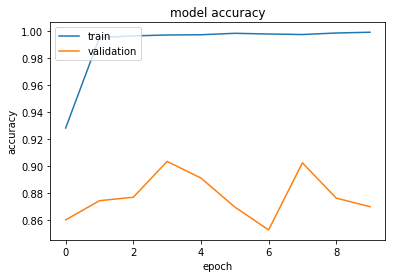

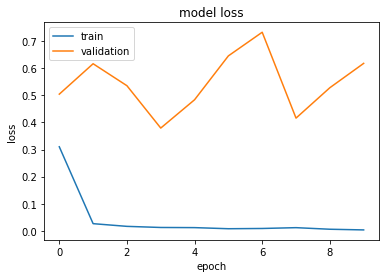

In [12]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.train.weights.train.Xception825.hdf5', 
                               verbose=1, save_best_only=True)
history = model.fit(x=train_tensors, y=np.asarray(train_lable), epochs=10, callbacks=[checkpointer], verbose=2,
                              batch_size=16, validation_data=(valid_tensors, np.asarray(valid_lable)))

plot_loss_acc(history)

### Check prediction on validation set

In [8]:
model.load_weights('saved_models/weights.train.weights.train.Xception825.hdf5')

In [61]:
v_err = []
vl = np.asarray(valid_lable)

for index in tqdm(range(len(valid_files))):
    img = cv2.imread(valid_files[index])
    img = cv2.resize(img, size299)
    x = img.copy()
    x.astype(np.uint8)
    prediction = model.predict(np.expand_dims(x, axis=0))
    #if np.argmax(prediction) != np.argmax(vl[index]):
    v_err.append([valid_files[index],np.argmax(prediction),np.argmax(vl[index])])

#print(len(v_err))

100%|██████████████████████████████████████████████████████████████████████████████| 4706/4706 [01:12<00:00, 64.79it/s]


In [62]:
#print(v_err[600][2])
vmap = np.zeros((10, 10),dtype=np.int16)
for i in range(10):
    vmap[i][i] = len(valid_lable)-len(v_err)
for err in v_err:
    vmap[err[2]][err[1]]+=1
print(vmap)

[[468   1  11   0   0   1   0   3   6   9]
 [  5 466   1   0   0   0   1   0   2   6]
 [  0   0 432   0   0   0   1   3  52   0]
 [  4   0   0 483   1   0   0   0   0   0]
 [ 16   0   4   1 334   0   1   0  88  57]
 [  7   0   2   0   0 476   0   0   0  10]
 [  0   2   2   0   0   0 433   1  56   0]
 [  2   0  31   0   0   0   0 353  26   7]
 [ 16   1  54   0   3   0  26   6 311   8]
 [204   0  20   0   0   4   1   1  15 171]]


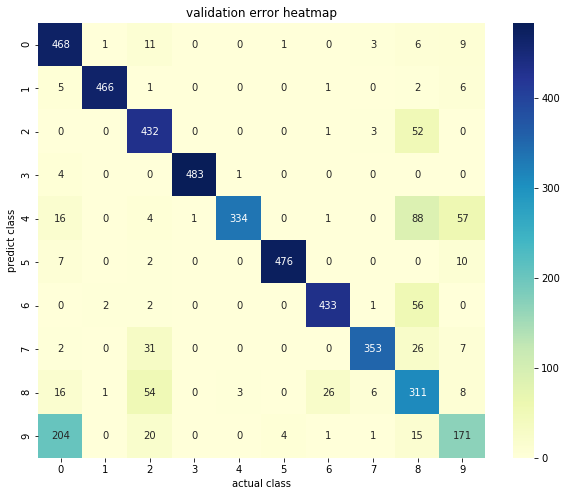

In [71]:
fig, ax = plt.subplots(figsize=(10,8)) 
ax.set_title("validation error heatmap")
#plt.axes().set_title("validation error heatmap")
sns.heatmap(vmap, annot=True, fmt='g', cmap='YlGnBu',ax=ax)
ax.set_xlabel('actual class')
ax.set_ylabel('predict class')
plt.show()

### CAM Visualize

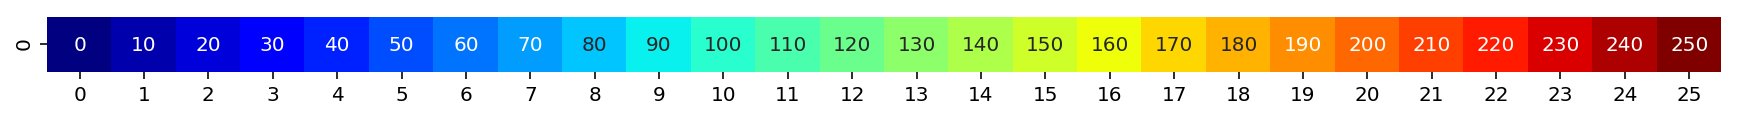

In [5]:
%config InlineBackend.figure_format = 'retina'

test_path = "test"
test_files =os.listdir(test_path)
d_status = {0:'safe driving', 1:'texting(R)', 2:'talking on the phone(R)', 3:'texting(L)', 4:'talking on the phone(L)',
           5:'operating the radio', 6:'drinking', 7:'reaching behind', 8:'hair and makeup',9:'talking to passenger'}
def plot_some_samples(Model, weights, img_size):
    plt.figure(figsize=(12, 14))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        img = cv2.imread('test/%s' %random.choice(test_files))
        img = cv2.resize(img, img_size)
        x = img.copy()
        x.astype(np.float32)
        out, prediction = model2.predict(np.expand_dims(x, axis=0))

        b = np.argmax(prediction)
        #print(out.shape, prediction.shape)
        prediction = prediction[0]
        out = out[0]
        #print(out.shape)

        plt.title(d_status[b])
    
        cam = (prediction - 0.5) * np.matmul(out, weights)
        cam -= cam.min()
        cam /= cam.max()
        cam -= 0.2
        cam /= 0.8
        cam = cam[:,:,b]
        cam = cv2.resize(cam, img_size)
        #print(cam.shape)
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0

        out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

        plt.axis('off')
        plt.imshow(out[:,:,::-1])
        
import seaborn as sns
plt.figure(figsize=(15, 0.5))
heatband = np.array([range(0,255,10)])
#print(heatband)
sns.heatmap(heatband, annot=True, fmt="d", cmap='jet', cbar=False)
plt.show()

### Predict test set

In [14]:
test_pd = pd.read_csv('sample_submission.csv')
#display first record
display(test_pd.head(n=2))
#test_cpd = test_pd
print(test_pd.img.count())

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


79726


In [15]:
def generate_pred_csv(size):
    for index in tqdm(range(test_pd.img.count())):
        img = cv2.imread('test/%s' %test_pd.img[index])
        img = cv2.resize(img, size)
        x = img.copy()
        x.astype(np.uint8)
        prediction = model.predict(np.expand_dims(x, axis=0))
        for i in range(10):
            test_pd.set_value(index, classes[i], prediction[0][i])
            
def generate_pred_clip_csv(size, pmax=0.995, pmin=0.005):
    for index in tqdm(range(test_pd.img.count())):
        img = cv2.imread('test/%s' %test_pd.img[index])
        img = cv2.resize(img, size)
        x = img.copy()
        x.astype(np.uint8)
        prediction = model.predict(np.expand_dims(x, axis=0))
        prediction = prediction.clip(min = pmin, max = pmax)
        #c_prediction = prediction.clip(min = pmin, max = pmax)
        for i in range(10):
            test_pd.set_value(index, classes[i], prediction[0][i])
            #test_cpd.set_value(index, classes[i], c_prediction[0][i])

In [16]:
generate_pred_clip_csv(size299, pmax=0.999, pmin=0.001)
test_pd.to_csv('test_Xception825_3.csv', index=None)

100%|████████████████████████████████████████████████████████████████████████████| 79726/79726 [29:52<00:00, 37.06it/s]
